# DMC Example: Forces for the Infinite Elliptical Well in 2D

This example shows how to use DMC for a 2D single-particle example, namely, the elliptical box. This is modeled by the Hamiltonian

$$
    H = -\frac{1}{2}\nabla^2
$$

for $x \in \mathcal{E}$, with $\mathcal{E}$ an ellipse centered at the origin with foci at $x_1 = \pm a$. The exact ground state wave function is

$$
    \Psi_0 = \mathrm{Ce}_0(\mu, q_{00})\mathrm{ce}_0(\nu, q_{00}),
$$

with $q_{00} = 0.8253525490491695$, $\mathrm{Ce}_m$ the modified cosine-extended Mathieu function of order $m$, and $\mathrm{ce}_n$ the cosine-extended Mathieu function of order $n$. The parameter $q_{mn}$ is quantized due to the homogeneous Dirichlet boundary condition at $\partial \mathcal{E}$; it determines the energy via

$$
    E_{mn} = 2q_{mn}/a^2.
$$

Thus, the exact ground state energy is $E_{00} = 1.65071$.

## Set up a DMC Run

We proceed to set up a DMC simulation of the elliptical well:

In [1]:
import sys
sys.path.insert(0, "../")
from pydmc import *
%matplotlib inline

In [2]:
q0 = 0.8253525490491695
a0 = 1
nconf = 50
time_step = 1e-2
reference_energy = 3.67603
blocks = 100
steps_per_block = 10
# number of equilibration blocks
neq = 10
hamiltonian = lambda psi, x: -0.5*psi.laplacian(x)
da = 1e-4

As a trial wave function, we use something with the same nodes at the boundary of the ellipse as the analytical ground state. We use $\Psi_G = x\Psi_0(x, y)$,
which has a variational energy of

$$
    E_V = 3.67603.
$$

We wish to use DMC to estimate the "force"

$$
    F = -\frac{\partial E}{\partial a},
$$

which in VMC can be done using the formula

$$
    F = -\left\langle \frac{\partial E_L}{\partial a} + (E_L - E) \frac{\partial}{\partial a}\ln(\pi) \right\rangle,
$$

where $\pi$ indicates the variational distribution $\pi(x) = \Psi_G(x)^2$. In this simple example, one can evaluate the force exactly by using trapezoidal integration, from which we find $F = 7.35205$. 

For DMC, the situation is a little more complicated, as we do not have an explicit expression for the mixed distribution. The analogous formula for DMC will be given below.

In [3]:
import scipy.special as spec

def mathieu_modcem1(m, q, x):
    return spec.mathieu_modcem1(m, q, x)

def mathieu_cem(m, q, x):
    # Angular mathieu function in scipy takes input
    # in degrees
    return spec.mathieu_cem(m, q, x*180/np.pi)

def ground_state(mu, nu):
    return mathieu_modcem1(0, q0, mu)[0]*mathieu_cem(0, q0, nu)[0]

class GuidingWaveFunction(WaveFunction, GeometryParametrized):

    def __init__(self, a):
        self._a = a

    def __call__(self, x):
        x, y = x
        #alpha = self._a[0]*np.cosh(1)
        #beta = self._a[0]*np.sinh(1)
        #r = np.sqrt((x/alpha)**2 + (y/beta)**2)
        #return (r + 1)/2 * (1 - (r+1)/2)
        mu = np.real(np.arccosh((x + 1j*y)/self._a[0]))
        nu = np.imag(np.arccosh((x + 1j*y)/self._a[0]))
        return x*ground_state(mu, nu)

    def gradient(self, x):
        return gradient_fd(self, x)
    
    def laplacian(self, x):
        return laplacian_fd(self, x)

    def geometry_parameters(self):
        return self._a

    def deform(self, parameter_change):
        return GuidingWaveFunction(self._a + parameter_change)

## "Drifdifgfunc" method

Since in DMC, we do not have direct access to the distribution $\pi(x)$, we cannot use the same expression used for the forces in VMC. Instead, we use the VD approximation, wherein the forces are calculated as

$$
    F = -\left\langle
        \nabla_a E_L(x_n) + [E_L(x_n) - E]\left(
            \sum_{i=n-k}^{n-1}\nabla_a \ln G(x_{i+1}, x_i) + \nabla_a \ln \pi(x_{n-k}) 
        \right)
    \right\rangle,
$$

where $G$ denotes the drift-diffusion Green function; disregarding normalization,

$$
    G(x_{i+1}, x_i) = \exp\left(
        -\frac{(x_{i+1} - x_i - V(x_i)\tau)^2}{2\tau}
    \right)
    \exp\left(
        S(x_{i+1}, x_i)
    \right)
$$

with

$$
    S(x_{i+1}, x_i) = \tau\left(
        E_{ref} - \frac{1}{2}(E_L(x_{i+1}) + E_L(x_i)),
    \right)
$$

and $k$ is chosen such that $\pi(x_{n-k})$ and $E_L(x_n)$ are uncorrelated. For simplicity, we just take $k$ to be the block size. In the code below, this expression is evaluated using finite differences. To do this, we accumulate samples for both a primary and a secondary geometry, where the ellipse is stretched by displacing the foci by $\Delta a$ in either direction.

In [4]:
def dmc(da, warp, force_method="drifdifgfunc"):
    brancher = SRBrancher()
    #brancher = SimpleBrancher()
    #brancher = SplitJoinBrancher()
    #brancher = NoBrancher()

    ar = DiffuseAcceptReject(fixed_node=True)
    guiding_wf = GuidingWaveFunction(np.array([a0]))

    np.random.seed(0)
    confs = [np.random.uniform(low=-1, high=1, size=2) for _ in range(nconf)]
    walkers = [Walker(conf, 1.0) for conf in confs]

    if force_method == "drifdifgfunc":
        fa = ForcesDriftDifGfunc(np.array([da]), nconf, warp=warp)
    elif force_method == "vd":
        fa = ForcesVD(np.array([da]), nconf, warp=warp)
    else:
        raise NotImplementedError("Force algorithm not implemented")

    dmc = DMC(hamiltonian, walkers, brancher, ar, guiding_wf, reference_energy, force_accumulator=fa)
    dmc.run_dmc(time_step, blocks, steps_per_block, neq=neq, progress=True)

    return dmc

In [6]:
dmcres_nowarp = dmc(da, False, force_method="drifdifgfunc")

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


Now we repeat the calculation with the node warp transformation enabled:

In [7]:
dmcres_warp = dmc(da, True, force_method="drifdifgfunc")

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


Obtain the results for the DMC energy and its estimated error:

In [8]:
energy = dmcres_nowarp.energy_estimate[-1]
err = dmcres_nowarp.energy_error[-1]
print(f"DMC Energy:   {energy:.5f} +/- {err:.5f}")
print(f"Variational:  {reference_energy:.5f}")
print(f"Exact:        {2*q0/a0**2:.5f}")

DMC Energy:   3.61825 +/- 0.01731
Variational:  3.67603
Exact:        1.65071


See how the energy estimate evolved over time:

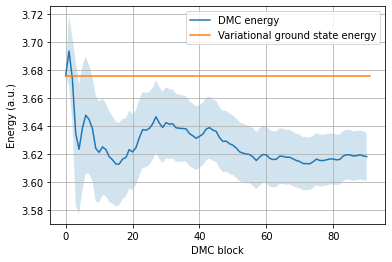

In [9]:
plt.figure()
ns = np.arange(0, len(dmcres_nowarp.energy_estimate))
plt.plot(ns, dmcres_nowarp.energy_estimate, label="DMC energy")
plt.fill_between(ns, dmcres_nowarp.energy_estimate - dmcres_nowarp.energy_error, 
                     dmcres_nowarp.energy_estimate + dmcres_nowarp.energy_error, alpha=0.2)

plt.plot([0, len(dmcres_nowarp.energy_estimate)], 
        [reference_energy, reference_energy], label="Variational ground state energy")
plt.legend()
plt.xlabel("DMC block")
plt.ylabel("Energy (a.u.)")
plt.grid()

Finally, we extract the data necessary to compute the force estimate. The work to compute the force is done in a separate function.

DMC force: 10.74767 +/- 0.13802


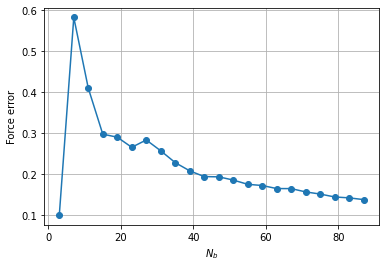

In [10]:
fa = dmcres_nowarp.force_accumulator
errs = []
bs = list(range(3, blocks-neq, (blocks-neq)//20))
for b in bs:
    nconf = b * steps_per_block
    fl_nowarp, f_nowarp = fa.compute_forces(steps_per_block, nconf)
    f_err_nowarp = block_error(fl_nowarp[0, :], block_size=steps_per_block)
    errs.append(f_err_nowarp)

plt.plot(bs, errs, marker='o'); plt.xlabel("$N_b$"); plt.ylabel("Force error")
plt.grid()
print(f"DMC force: {f_nowarp[0]:.5f} +/- {f_err_nowarp:.5f}")

Do the same with the warped results:

DMC force: 10.12330 +/- 0.12321


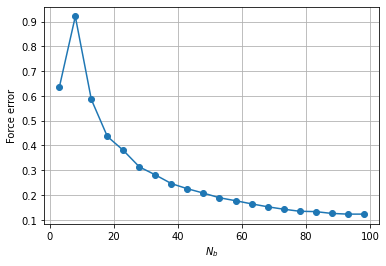

In [11]:
fa = dmcres_warp.force_accumulator
errs = []
bs = list(range(3, blocks, blocks//20))
for b in bs:
    nconf = b * steps_per_block
    fl_warp, f_warp = fa.compute_forces(steps_per_block, nconf)
    f_err_warp = block_error(fl_warp[0, :], block_size=steps_per_block)
    errs.append(f_err_warp)

plt.plot(bs, errs, marker='o'); plt.xlabel("$N_b$"); plt.ylabel("Force error")
plt.grid()
print(f"DMC force: {f_warp[0]:.5f} +/- {f_err_warp:.5f}")

Compare the data traces between the local force with and without node warp

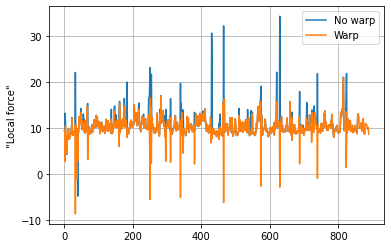

In [13]:
plt.plot(bin_samples(fl_nowarp[0, :], bin_size=1), label="No warp")
plt.plot(bin_samples(fl_warp[0, :], bin_size=1), label="Warp")
plt.legend(); plt.grid(); plt.ylabel("\"Local force\"");

## VD Method

Another possibility for computing the forces in DMC. It amounts to using a different differential formula for the force, namely,

$$
    F = -\left\langle \nabla_a E_L(x_n) + (E_L(x_n) -E) \left(
            2\nabla_a \ln \Psi + \sum_{i=n-k}^{n-1}\nabla_a S(x_{i+1}, x_i)
        \right).
    \right\rangle
$$

This formulation has smaller fluctuations, as the noisiest part of the Green function is not included in the statistical average. Consequently, the node warp transformation should be significantly less effective for this algorithm.

In [5]:
dmcres_nowarp = dmc(da, False, force_method="vd")
dmcres_warp = dmc(da, True, force_method="vd")

100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


DMC force: 7.58638 +/- 0.07728


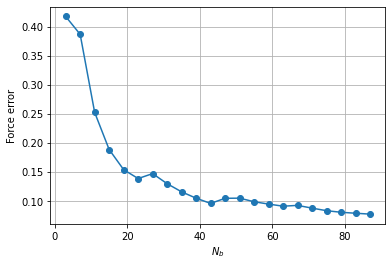

In [6]:
fa = dmcres_nowarp.force_accumulator
errs = []
bs = list(range(3, blocks-neq, (blocks-neq)//20))
for b in bs:
    nconf = b * steps_per_block
    fl_nowarp, f_nowarp = fa.compute_forces(steps_per_block, nconf)
    f_err_nowarp = block_error(fl_nowarp[0, :], block_size=steps_per_block)
    errs.append(f_err_nowarp)

plt.plot(bs, errs, marker='o'); plt.xlabel("$N_b$"); plt.ylabel("Force error")
plt.grid()
print(f"DMC force: {f_nowarp[0]:.5f} +/- {f_err_nowarp:.5f}")

DMC force: 6.97871 +/- 0.19877


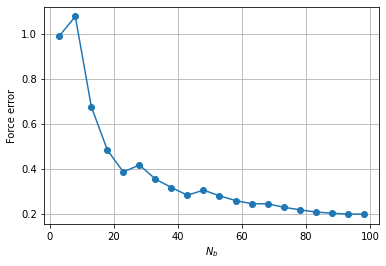

In [7]:
fa = dmcres_warp.force_accumulator
errs = []
bs = list(range(3, blocks, blocks//20))
for b in bs:
    nconf = b * steps_per_block
    fl_warp, f_warp = fa.compute_forces(steps_per_block, nconf)
    f_err_warp = block_error(fl_warp[0, :], block_size=steps_per_block)
    errs.append(f_err_warp)

plt.plot(bs, errs, marker='o'); plt.xlabel("$N_b$"); plt.ylabel("Force error")
plt.grid()
print(f"DMC force: {f_warp[0]:.5f} +/- {f_err_warp:.5f}")

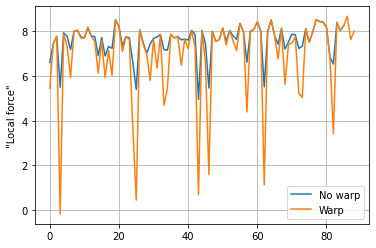

In [8]:
plt.plot(bin_samples(fl_nowarp[0, :], bin_size=steps_per_block), label="No warp")
plt.plot(bin_samples(fl_warp[0, :], bin_size=steps_per_block), label="Warp")
plt.legend(); plt.grid(); plt.ylabel("\"Local force\"");